In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
import tensorflow as tf

In [2]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Basic RNN
illustrates a layer of 5 recurrent neurons 

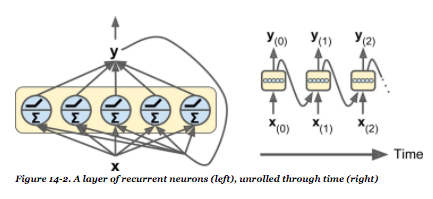

In [3]:
import time
d = np.int32(time.time())
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

input of four instances:
Each instance represents a sampled random process

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val_, Y1_val_ = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
Y0_val_
#np.sum(Y0_val-Y0_val_,axis=0)

array([[-0.0664006 ,  0.96257669,  0.68105793,  0.70918542, -0.89821601],
       [ 0.9977755 , -0.71978903, -0.99657607,  0.96739239, -0.99989718],
       [ 0.99999774, -0.99898803, -0.99999893,  0.99677622, -0.99999988],
       [ 1.        , -1.        , -1.        , -0.99818915,  0.99950868]], dtype=float32)

In [6]:
Y1_val_
#Y1_val-Y1_val_

array([[ 1.        , -1.        , -1.        ,  0.40200251, -0.99999982],
       [-0.12210421,  0.62805271,  0.96718431, -0.99371219, -0.25839362],
       [ 0.99999827, -0.9999994 , -0.9999975 , -0.85943311, -0.99998808],
       [ 0.99928284, -0.99999815, -0.99990582,  0.98579627, -0.92205757]], dtype=float32)

# Using static_rnn()
run with fixed time steps

In [7]:
n_inputs = 3
n_neurons = 5
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

In [8]:
init = tf.global_variables_initializer()
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1
with tf.Session() as sess:
    init.run()
    X1_size=X1.eval(feed_dict={X0: X0_batch, X1: X1_batch}).shape
    [Y0_valS, Y1_valS] = sess.run([Y0,Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    pass

In [9]:
print(X1_size)
Y0_valS

(4, 3)


array([[ 0.30741334, -0.32884315, -0.65428472, -0.93850589,  0.52089024],
       [ 0.99122757, -0.95425421, -0.75180793, -0.99952078,  0.98202348],
       [ 0.99992681, -0.99783254, -0.82473528, -0.9999963 ,  0.99947774],
       [ 0.99677098, -0.68750614,  0.84199691,  0.93039107,  0.8120684 ]], dtype=float32)

In [10]:
Y1_valS

array([[ 0.99998885, -0.99976051, -0.06679298, -0.99998039,  0.99982214],
       [-0.65249437, -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.99862403, -0.99715197, -0.03308626, -0.99915648,  0.99329019],
       [ 0.99681675, -0.95981938,  0.39660636, -0.83076048,  0.79671967]], dtype=float32)

In [11]:
#show_graph(tf.get_default_graph())

# Static rnn () extension - Packing sequences
run pre-programmable time steps

In [12]:
n_steps = 3
n_inputs = 3
n_neurons = 5
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,
                                                dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [13]:
init = tf.global_variables_initializer()
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7],[1,2,3]], # instance 1
        [[3, 4, 5], [0, 0, 0],[1,2,3]], # instance 2
        [[6, 7, 8], [6, 5, 4],[1,2,3]], # instance 3
        [[9, 0, 1], [3, 2, 1],[1,2,3]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [14]:
outputs_val

array([[[-0.45652324, -0.68064123,  0.40938237,  0.63104504, -0.45732826],
        [-0.94288003, -0.99988687,  0.94055814,  0.99999851, -0.9999997 ],
        [-0.91355228, -0.88120127,  0.86075819,  0.97106743, -0.97472709]],

       [[-0.80015349, -0.99218267,  0.78177971,  0.9971031 , -0.99646091],
        [-0.63711601,  0.11300932,  0.5798437 ,  0.43105593, -0.63716984],
        [-0.80634809, -0.93940139,  0.67856741,  0.94907922, -0.96972144]],

       [[-0.93605185, -0.99983788,  0.93088669,  0.99998152, -0.99998295],
        [-0.9165386 , -0.99456042,  0.89605415,  0.99987197, -0.99997509],
        [-0.90877151, -0.87994462,  0.86025721,  0.96978194, -0.97464114]],

       [[ 0.99273688, -0.99819332, -0.55543643,  0.9989031 , -0.9953323 ],
        [-0.02746334, -0.73191994,  0.7827872 ,  0.95256817, -0.97817713],
        [-0.88796663, -0.9282189 ,  0.87874389,  0.97578281, -0.94433916]]], dtype=float32)

As seen, the graph hard code all unrolled step of each neuron layers It will occupy a lot of memory for large steps

In [15]:
show_graph(tf.get_default_graph())

# Using dynamic_rnn()

In [27]:
n_steps = 3
n_inputs = 3
n_neurons = 5
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,swap_memory=True)

In [28]:
init = tf.global_variables_initializer()
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7],[1,2,3]], # instance 1
        [[3, 4, 5], [0, 0, 0],[0,0,0]], # instance 2
        [[6, 7, 8], [6, 5, 4],[1,2,3]], # instance 3
        [[9, 0, 1], [3, 2, 1],[1,2,3]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [29]:
outputs_val

array([[[-0.0948875 , -0.78635412, -0.75976855,  0.81456447, -0.86596668],
        [-0.99999809, -0.99989897, -0.99999422,  0.99959809, -0.4085584 ],
        [-0.5340997 , -0.91768241, -0.95127553,  0.96605945, -0.95754999]],

       [[-0.98823678, -0.99379838, -0.99848306,  0.99407357, -0.9553898 ],
        [ 0.21658944, -0.20340651,  0.02591269,  0.44528607, -0.40116802],
        [ 0.14433643, -0.13857844,  0.05772887, -0.03391143,  0.17604975]],

       [[-0.99991536, -0.99983823, -0.99999166,  0.99982721, -0.98561245],
        [-0.99981058, -0.99268609, -0.99952865,  0.99385983, -0.25559649],
        [-0.51353109, -0.90375239, -0.95142502,  0.96238881, -0.9570052 ]],

       [[-0.99883717,  0.84198505, -0.97267133, -0.86984301,  0.99912703],
        [-0.97511095, -0.34840977, -0.92128128,  0.39821982,  0.27953893],
        [-0.53998083, -0.86585611, -0.95581222,  0.94449866, -0.95552593]]], dtype=float32)

In [30]:
show_graph(tf.get_default_graph())

# Setting variable sequence length

In [31]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length,swap_memory=True)

In [40]:
init = tf.global_variables_initializer()
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5],[0,0,0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [41]:
outputs_val

array([[[ 0.73155707,  0.34835717,  0.50581998, -0.22882833, -0.44022718],
        [-0.61832315,  0.99999994,  0.86584806,  0.97933769,  0.9902246 ]],

       [[ 0.8438704 ,  0.99697548,  0.84789461,  0.4303219 ,  0.09275495],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.91159219,  0.99999052,  0.95954454,  0.81892216,  0.57740247],
        [-0.77545464,  0.99987745,  0.97847283,  0.73172009,  0.888776  ]],

       [[-0.99952269,  0.99977839,  0.59744656,  0.99309695,  0.99847412],
        [-0.62120003,  0.54000849,  0.96938425,  0.19893228,  0.1944804 ]]], dtype=float32)

In [42]:
states_val #contain the final state of output_val

array([[-0.61832315,  0.99999994,  0.86584806,  0.97933769,  0.9902246 ],
       [ 0.8438704 ,  0.99697548,  0.84789461,  0.4303219 ,  0.09275495],
       [-0.77545464,  0.99987745,  0.97847283,  0.73172009,  0.888776  ],
       [-0.62120003,  0.54000849,  0.96938425,  0.19893228,  0.1944804 ]], dtype=float32)

In [48]:
outputs_val[:,-1,:]

array([[-0.61832315,  0.99999994,  0.86584806,  0.97933769,  0.9902246 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.77545464,  0.99987745,  0.97847283,  0.73172009,  0.888776  ],
       [-0.62120003,  0.54000849,  0.96938425,  0.19893228,  0.1944804 ]], dtype=float32)

# Training a sequence classifier
Note: the book uses tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:

several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
the default activation is now None rather than tf.nn.relu.